<a href="https://colab.research.google.com/github/alyazakhira/embedding-compare/blob/main/compare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Requirements

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install fasttext
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.bin.gz
!gunzip cc.id.300.bin.gz

--2025-06-13 06:19:39--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.173.166.48, 18.173.166.51, 18.173.166.31, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.173.166.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4507049071 (4.2G) [application/octet-stream]
Saving to: ‘cc.id.300.bin.gz’

cc.id.300.bin.gz    100%[===================>]   4.20G  24.5MB/s    in 77s     

2025-06-13 06:20:57 (55.6 MB/s) - ‘cc.id.300.bin.gz’ saved [4507049071/4507049071]



In [ ]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import csv
import string
import re

import torch
import nltk
import tensorflow as tf
from nltk import pos_tag
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix, classification_report
from transformers import BertTokenizer, BertModel
import tensorflow_hub as hub
# import fasttext

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
# bert_tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
# bert_model = BertModel.from_pretrained('indobenchmark/indobert-base-p1')
elmo = hub.load("https://www.kaggle.com/models/google/elmo/TensorFlow1/elmo/3")
# ft_model = fasttext.load_model('cc.id.300.bin')
id_wn = wn

# Dataset

In [ ]:
data_sport = pd.read_csv("drive/My Drive/Proyek Akhir/Dataset/Dataset Fix/sport_processed.csv", delimiter=',')
data_pol = pd.read_csv("drive/My Drive/Proyek Akhir/Dataset/Dataset Fix/politics_processed.csv", delimiter=',')
data_life = pd.read_csv("drive/My Drive/Proyek Akhir/Dataset/Dataset Fix/lifestyle_processed.csv", delimiter=',')
data_tech = pd.read_csv("drive/My Drive/Proyek Akhir/Dataset/Dataset Fix/technology_processed.csv", delimiter=',')

In [ ]:
data_life.head()

,question_id,student_answer,key_answer,manual_average_score,label
0,lifestyle_1,"sumber tenaga, pemanis alami, menjaga sistem i...",Fungsi karbohidrat adalah sebagai pemasok ener...,26.666667,0
1,lifestyle_1,"sebagai sumber energi, pemanis alami, menjaga ...",Fungsi karbohidrat adalah sebagai pemasok ener...,21.000000,0
2,lifestyle_1,1. Sebagai energi. 2. Sebagai memperlancaar pe...,Fungsi karbohidrat adalah sebagai pemasok ener...,41.666667,0
3,lifestyle_1,"untuk membuat kenyang, agar tidak lapar, agar ...",Fungsi karbohidrat adalah sebagai pemasok ener...,18.333333,0
4,lifestyle_1,Karbohidrat mempunyai peran penting untuk pros...,Fungsi karbohidrat adalah sebagai pemasok ener...,81.666667,1


In [ ]:
data_life.iloc[526]

,526
question_id,lifestyle_10
student_answer,-
key_answer,Otak merupakan bagian terpenting dari tubuh ma...
manual_average_score,1.0
label,0


# Function

## Pre-processing

### Data Preprocessing

In [ ]:
def data_preprocess(df):
  df_clean = df.dropna()                                                                            # Remove missing values
  df_clean = df[~df['student_answer'].apply(lambda x: isinstance(x, str) and len(x.strip()) == 1)]  # Remove rows with 1 character strings
  return df_clean

In [ ]:
data_life = data_preprocess(data_life)
data_sport = data_preprocess(data_sport)
data_pol = data_preprocess(data_pol)
data_tech = data_preprocess(data_tech)

### Text Preprocessing

In [ ]:
def replace_punctuation(text):
  text = text.replace('/',' atau ')
  text = text.replace('&',' dan ')
  return text

def truncate_text(text, max_tokens=512):
  tokens = word_tokenize(text)
  truncated_tokens = tokens[:max_tokens]
  return ' '.join(truncated_tokens)

def text_preprocessing(text):
  text = text.lower()                             # Casefolding
  text = replace_punctuation(text)                # Replace punctuation
  text = re.sub(r'\d+', '', text)                 # Remove numeric
  text = re.sub(r'\s+', ' ', text).strip()        # Whitespace normalization
  text = re.sub(r'[^\w\s]', '', text)
  text = truncate_text(text)                      # Truncate to 512 token
  return text

## Expand Text

In [ ]:
def get_wordnet_pos(treebank_tag):
    """Maps Penn Treebank POS to Wordnet POS."""
    if treebank_tag.startswith('J'):
        return 'a'  # Adjective
    elif treebank_tag.startswith('V'):
        return 'v'  # Verb
    elif treebank_tag.startswith('N'):
        return 'n'  # Noun
    elif treebank_tag.startswith('R'):
        return 'r'  # Adverb
    else:
        return None

def expand_text(text, max_synonyms=2):
    """Expand text by adding smart synonyms from Wordnet."""
    words = word_tokenize(text)
    pos_tags = pos_tag(words)
    expanded_words = []

    for word, tag in pos_tags:
        wn_pos = get_wordnet_pos(tag)
        if wn_pos:
            # Get synonyms from Wordnet
            synsets = id_wn.synsets(word, pos=wn_pos, lang='ind')
            lemmas = set()
            for synset in synsets:
                for lemma in synset.lemmas():
                    lemmas.add(lemma.name())
            selected_synonyms = list(lemmas)[:max_synonyms]
            expanded_words.append(word)
            expanded_words.extend(selected_synonyms)
        else:
            expanded_words.append(word)

    expanded_text = ' '.join(expanded_words)
    return expanded_text

## Text Embedding: BERT

In [ ]:
def embed_text_bert(text):
  tokenized_text = bert_tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
  with torch.no_grad():
      embedding = bert_model(**tokenized_text)
  squeezed_embedding = embedding.last_hidden_state.squeeze(0) # Extract the token embedding
  avg_embedding = squeezed_embedding.mean(dim=0).numpy() # Count average
  return avg_embedding

## Text Embedding: ELMo

In [ ]:
def embed_text_elmo(text):
  text = tf.constant([text])
  embedding = elmo.signatures["default"](text)["elmo"]
  squeezed_embedding = tf.squeeze(embedding, axis=0) # Extract
  avg_embedding = tf.reduce_mean(squeezed_embedding, axis=0).numpy() # Count average, convert to numpy
  return avg_embedding

## Text Embedding: Fasttext

In [ ]:
def embed_text_ft(text):
  words = text.split()
  vectors = [ft_model.get_word_vector(word) for word in words]
  avg_embedding = np.mean(vectors, axis=0)
  return avg_embedding

## Compute Similarity

In [ ]:
def sim_result(text, ref, threshold = 0.7):
  sim_matrix = cosine_similarity(text,ref)
  if threshold:
    pred_matrix = (sim_matrix > threshold).astype(int)
    pred_result = np.diagonal(pred_matrix)
    return pred_result                        # return list of binary result
  else:
    sim_result = np.diagonal(sim_matrix)
    return sim_result

# Main Process
Note: CM format [ [TN, FP], [FN, TP] ]

## Process Text

In [ ]:
# Converted DataFrame
data_text_life = data_life['student_answer'].tolist()
data_ref_life = data_life['key_answer'].tolist()
data_text_sport = data_sport['student_answer'].tolist()
data_ref_sport = data_sport['key_answer'].tolist()
data_text_pol = data_pol['student_answer'].tolist()
data_ref_pol = data_pol['key_answer'].tolist()
data_text_tech = data_tech['student_answer'].tolist()
data_ref_tech = data_tech['key_answer'].tolist()

# Preprocessed text
data_text_life = [text_preprocessing(text) for text in data_text_life]
data_ref_life = [text_preprocessing(ref) for ref in data_ref_life]
data_text_sport = [text_preprocessing(text) for text in data_text_sport]
data_ref_sport = [text_preprocessing(ref) for ref in data_ref_sport]
data_text_life = [text_preprocessing(text) for text in data_text_life]
data_text_pol = [text_preprocessing(ref) for ref in data_text_pol]
data_text_tech = [text_preprocessing(text) for text in data_text_tech]
data_ref_tech = [text_preprocessing(ref) for ref in data_ref_tech]

# WordNet processed text
expanded_text_life = [expand_text(text) for text in data_text_life]
expanded_ref_life = [expand_text(ref) for ref in data_ref_life]
expanded_text_sport = [expand_text(text) for text in data_text_sport]
expanded_ref_sport = [expand_text(ref) for ref in data_ref_sport]
expanded_text_pol = [expand_text(text) for text in data_text_pol]
expanded_ref_pol = [expand_text(ref) for ref in data_ref_pol]
expanded_text_tech = [expand_text(text) for text in data_text_tech]
expanded_ref_tech = [expand_text(ref) for ref in data_ref_tech]

## Data: Lifestyle

In [ ]:
# BERT no expand
embed_text_life_bert_ne = np.array([embed_text_bert(text) for text in data_text_life])
embed_ref_life_bert_ne = np.array([embed_text_bert(ref) for ref in data_ref_life])

# Compute similarity
pred = sim_result(embed_text_life_bert_ne, embed_ref_life_bert_ne)

# Evaluation
cm = confusion_matrix(data_life['label'].to_numpy(), pred)
report_bert_life_ne = classification_report(data_life['label'].to_numpy(), pred)

print(cm)
print(report_bert_life_ne)

In [ ]:
# BERT expand
embed_text_life_bert_e = np.array([embed_text_bert(text) for text in expanded_text_life])
embed_ref_life_bert_e = np.array([embed_text_bert(ref) for ref in expanded_ref_life])

# Compute similarity
pred = sim_result(embed_text_life_bert_e, embed_ref_life_bert_e)

# Evaluation
cm = confusion_matrix(data_life['label'].to_numpy(), pred)
report_bert_life_e = classification_report(data_life['label'].to_numpy(), pred)

print(cm)
print(report_bert_life_e)

In [ ]:
# ELMo no expand
embed_text_life_elmo_ne = np.array([embed_text_elmo(text) for text in data_text_life])
embed_ref_life_elmo_ne = np.array([embed_text_elmo(ref) for ref in data_ref_life])

# Compute similarity
pred = sim_result(embed_text_life_elmo_ne, embed_ref_life_elmo_ne)

# Evaluation
cm = confusion_matrix(data_life['label'].to_numpy(), pred)
report_elmo_life_ne = classification_report(data_life['label'].to_numpy(), pred)

print(cm)
print(report_elmo_life_ne)

[[ 40 511]
 [  0  15]]
              precision    recall  f1-score   support

           0       1.00      0.07      0.14       551
           1       0.03      1.00      0.06        15

    accuracy                           0.10       566
   macro avg       0.51      0.54      0.10       566
weighted avg       0.97      0.10      0.13       566



In [ ]:
# ELMo expand
embed_text_life_elmo_e = np.array([embed_text_elmo(text) for text in expanded_text_life]) # use wordnet processed text
embed_ref_life_elmo_e = np.array([embed_text_elmo(ref) for ref in expanded_ref_life])

# Compute similarity
pred = sim_result(embed_text_life_elmo_e, embed_ref_life_elmo_e)

# Evaluation
cm = confusion_matrix(data_life['label'].to_numpy(), pred)
report_elmo_life_e = classification_report(data_life['label'].to_numpy(), pred)

print(cm)
print(report_elmo_life_e)

[[ 44 507]
 [  0  15]]
              precision    recall  f1-score   support

           0       1.00      0.08      0.15       551
           1       0.03      1.00      0.06        15

    accuracy                           0.10       566
   macro avg       0.51      0.54      0.10       566
weighted avg       0.97      0.10      0.15       566



In [ ]:
# Fasttext no expand
embed_text_life_ft_ne = np.array([embed_text_ft(text) for text in data_text_life])
embed_ref_life_ft_ne = np.array([embed_text_ft(ref) for ref in data_ref_life])

# Compute similarity
pred = sim_result(embed_text_life_ft_ne, embed_ref_life_ft_ne)

# Evaluation
cm = confusion_matrix(data_life['label'].to_numpy(), pred)
report_ft_life_ne = classification_report(data_life['label'].to_numpy(), pred)

print(cm)
print(report_ft_life_ne)

In [ ]:
# Fasttext expand
embed_text_life_ft_e = np.array([embed_text_ft(text) for text in expanded_text_life])
embed_ref_life_ft_e = np.array([embed_text_ft(ref) for ref in expanded_ref_life])

# Compute similarity
pred = sim_result(embed_text_life_ft_e, embed_ref_life_ft_e)

# Evaluation
cm = confusion_matrix(data_life['label'].to_numpy(), pred)
report_ft_life_e = classification_report(data_life['label'].to_numpy(), pred)

print(cm)
print(report_ft_life_e)

## Data: Sport

In [ ]:
# BERT no expand
embed_text_sport_bert_ne = np.array([embed_text_bert(text) for text in data_text_sport])
embed_ref_sport_bert_ne = np.array([embed_text_bert(ref) for ref in data_ref_sport])

# Compute similarity
pred = sim_result(embed_text_sport_bert_ne, embed_ref_sport_bert_ne)

# Evaluation
cm = confusion_matrix(data_sport['label'].to_numpy(), pred)
report_bert_sport_ne = classification_report(data_sport['label'].to_numpy(), pred)

print(cm)
print(report_bert_sport_ne)

In [ ]:
# BERT expand
embed_text_sport_bert_e = np.array([embed_text_bert(text) for text in expanded_text_sport])
embed_ref_sport_bert_e = np.array([embed_text_bert(ref) for ref in expanded_ref_sport])

# Compute similarity
pred = sim_result(embed_text_sport_bert_e, embed_ref_sport_bert_e)

# Evaluation
cm = confusion_matrix(data_sport['label'].to_numpy(), pred)
report_bert_sport_e = classification_report(data_sport['label'].to_numpy(), pred)

print(cm)
print(report_bert_sport_e)

In [ ]:
# ELMo no expand
embed_text_sport_elmo_ne = np.array([embed_text_elmo(text) for text in data_text_sport])
embed_ref_sport_elmo_ne = np.array([embed_text_elmo(ref) for ref in data_ref_sport])

# Compute similarity
pred = sim_result(embed_text_sport_elmo_ne, embed_ref_sport_elmo_ne)

# Evaluation
cm = confusion_matrix(data_sport['label'].to_numpy(), pred)
report_elmo_sport_ne = classification_report(data_sport['label'].to_numpy(), pred)

print(cm)
print(report_elmo_sport_ne)

[[ 32 413]
 [  0  99]]
              precision    recall  f1-score   support

           0       1.00      0.07      0.13       445
           1       0.19      1.00      0.32        99

    accuracy                           0.24       544
   macro avg       0.60      0.54      0.23       544
weighted avg       0.85      0.24      0.17       544



In [ ]:
# ELMo expand
embed_text_sport_elmo_e = np.array([embed_text_elmo(text) for text in expanded_text_sport]) # use wordnet processed text
embed_ref_sport_elmo_e = np.array([embed_text_elmo(ref) for ref in expanded_ref_sport])

# Compute similarity
pred = sim_result(embed_text_sport_elmo_e, embed_ref_sport_elmo_e)

# Evaluation
cm = confusion_matrix(data_sport['label'].to_numpy(), pred)
report_elmo_sport_e = classification_report(data_sport['label'].to_numpy(), pred)

print(cm)
print(report_elmo_sport_e)

[[ 30 415]
 [  0  99]]
              precision    recall  f1-score   support

           0       1.00      0.07      0.13       445
           1       0.19      1.00      0.32        99

    accuracy                           0.24       544
   macro avg       0.60      0.53      0.22       544
weighted avg       0.85      0.24      0.16       544



In [ ]:
# Fasttext no expand
embed_text_sport_ft_ne = np.array([embed_text_ft(text) for text in data_text_sport])
embed_ref_sport_ft_ne = np.array([embed_text_ft(ref) for ref in data_ref_sport])

# Compute similarity
pred = sim_result(embed_text_sport_ft_ne, embed_ref_sport_ft_ne)

# Evaluation
cm = confusion_matrix(data_sport['label'].to_numpy(), pred)
report_ft_sport_ne = classification_report(data_sport['label'].to_numpy(), pred)

print(cm)
print(report_ft_sport_ne)

In [ ]:
# Fasttext expand
embed_text_sport_ft_e = np.array([embed_text_ft(text) for text in expanded_text_sport])
embed_ref_sport_ft_e = np.array([embed_text_ft(ref) for ref in expanded_ref_sport])

# Compute similarity
pred = sim_result(embed_text_sport_ft_e, embed_ref_sport_ft_e)

# Evaluation
cm = confusion_matrix(data_sport['label'].to_numpy(), pred)
report_ft_sport_e = classification_report(data_sport['label'].to_numpy(), pred)

print(cm)
print(report_ft_sport_e)

## Data: Politics

In [ ]:
# BERT no expand
embed_text_pol_bert_ne = np.array([embed_text_bert(text) for text in data_text_pol])
embed_ref_pol_bert_ne = np.array([embed_text_bert(ref) for ref in data_ref_pol])

# Compute similarity
pred = sim_result(embed_text_pol_bert_ne, embed_ref_pol_bert_ne)

# Evaluation
cm = confusion_matrix(data_pol['label'].to_numpy(), pred)
report_bert_pol_ne = classification_report(data_pol['label'].to_numpy(), pred)

print(cm)
print(report_bert_pol_ne)

In [ ]:
# BERT expand
embed_text_pol_bert_e = np.array([embed_text_bert(text) for text in expanded_text_pol])
embed_ref_pol_bert_e = np.array([embed_text_bert(ref) for ref in expanded_ref_pol])

# Compute similarity
pred = sim_result(embed_text_pol_bert_e, embed_ref_pol_bert_e)

# Evaluation
cm = confusion_matrix(data_pol['label'].to_numpy(), pred)
report_bert_pol_e = classification_report(data_pol['label'].to_numpy(), pred)

print(cm)
print(report_bert_pol_e)

In [ ]:
# ELMo no expand
embed_text_pol_elmo_ne = np.array([embed_text_elmo(text) for text in data_text_pol])
embed_ref_pol_elmo_ne = np.array([embed_text_elmo(ref) for ref in data_ref_pol])

# Compute similarity
pred = sim_result(embed_text_pol_elmo_ne, embed_ref_pol_elmo_ne)

# Evaluation
cm = confusion_matrix(data_pol['label'].to_numpy(), pred)
report_elmo_pol_ne = classification_report(data_pol['label'].to_numpy(), pred)

print(cm)
print(report_elmo_pol_ne)

[[  9 339]
 [ 49 137]]
              precision    recall  f1-score   support

           0       0.16      0.03      0.04       348
           1       0.29      0.74      0.41       186

    accuracy                           0.27       534
   macro avg       0.22      0.38      0.23       534
weighted avg       0.20      0.27      0.17       534



In [ ]:
# ELMo expand
embed_text_pol_elmo_e = np.array([embed_text_elmo(text) for text in expanded_text_pol]) # use wordnet processed text
embed_ref_pol_elmo_e = np.array([embed_text_elmo(ref) for ref in expanded_ref_pol])

# Compute similarity
pred = sim_result(embed_text_pol_elmo_e, embed_ref_pol_elmo_e)

# Evaluation
cm = confusion_matrix(data_pol['label'].to_numpy(), pred)
report_elmo_pol_e = classification_report(data_pol['label'].to_numpy(), pred)

print(cm)
print(report_elmo_pol_e)

[[  7 341]
 [  7 179]]
              precision    recall  f1-score   support

           0       0.50      0.02      0.04       348
           1       0.34      0.96      0.51       186

    accuracy                           0.35       534
   macro avg       0.42      0.49      0.27       534
weighted avg       0.45      0.35      0.20       534



In [ ]:
# Fasttext no expand
embed_text_pol_ft_ne = np.array([embed_text_ft(text) for text in data_text_pol])
embed_ref_pol_ft_ne = np.array([embed_text_ft(ref) for ref in data_ref_pol])

# Compute similarity
pred = sim_result(embed_text_pol_ft_ne, embed_ref_pol_ft_ne)

# Evaluation
cm = confusion_matrix(data_pol['label'].to_numpy(), pred)
report_ft_pol_ne = classification_report(data_pol['label'].to_numpy(), pred)

print(cm)
print(report_ft_pol_ne)

In [ ]:
# Fasttext expand
embed_text_pol_ft_e = np.array([embed_text_ft(text) for text in expanded_text_pol])
embed_ref_pol_ft_e = np.array([embed_text_ft(ref) for ref in expanded_ref_pol])

# Compute similarity
pred = sim_result(embed_text_pol_ft_e, embed_ref_pol_ft_e)

# Evaluation
cm = confusion_matrix(data_pol['label'].to_numpy(), pred)
report_ft_pol_e = classification_report(data_pol['label'].to_numpy(), pred)

print(cm)
print(report_ft_pol_e)

## Data: Technology

In [ ]:
# BERT no expand
embed_text_tech_bert_ne = np.array([embed_text_bert(text) for text in data_text_tech])
embed_ref_tech_bert_ne = np.array([embed_text_bert(ref) for ref in data_ref_tech])

# Compute similarity
pred = sim_result(embed_text_tech_bert_ne, embed_ref_tech_bert_ne)

# Evaluation
cm = confusion_matrix(data_tech['label'].to_numpy(), pred)
report_bert_tech_ne = classification_report(data_tech['label'].to_numpy(), pred)

print(cm)
print(report_bert_tech_ne)

In [ ]:
# BERT expand
embed_text_tech_bert_e = np.array([embed_text_bert(text) for text in expanded_text_tech])
embed_ref_tech_bert_e = np.array([embed_text_bert(ref) for ref in expanded_ref_tech])

# Compute similarity
pred = sim_result(embed_text_tech_bert_e, embed_ref_tech_bert_e)

# Evaluation
cm = confusion_matrix(data_tech['label'].to_numpy(), pred)
report_bert_tech_e = classification_report(data_tech['label'].to_numpy(), pred)

print(cm)
print(report_bert_tech_e)

In [ ]:
# ELMo no expand
embed_text_tech_elmo_ne = np.array([embed_text_elmo(text) for text in data_text_tech])
embed_ref_tech_elmo_ne = np.array([embed_text_elmo(ref) for ref in data_ref_tech])

# Compute similarity
pred = sim_result(embed_text_tech_elmo_ne, embed_ref_tech_elmo_ne)

# Evaluation
cm = confusion_matrix(data_tech['label'].to_numpy(), pred)
report_elmo_tech_ne = classification_report(data_tech['label'].to_numpy(), pred)

print(cm)
print(report_elmo_tech_ne)

[[ 41 368]
 [  3 101]]
              precision    recall  f1-score   support

           0       0.93      0.10      0.18       409
           1       0.22      0.97      0.35       104

    accuracy                           0.28       513
   macro avg       0.57      0.54      0.27       513
weighted avg       0.79      0.28      0.22       513



In [ ]:
# ELMo expand
embed_text_tech_elmo_e = np.array([embed_text_elmo(text) for text in expanded_text_tech]) # use wordnet processed text
embed_ref_tech_elmo_e = np.array([embed_text_elmo(ref) for ref in expanded_ref_tech])

# Compute similarity
pred = sim_result(embed_text_tech_elmo_e, embed_ref_tech_elmo_e)

# Evaluation
cm = confusion_matrix(data_tech['label'].to_numpy(), pred)
report_elmo_tech_e = classification_report(data_tech['label'].to_numpy(), pred)

print(cm)
print(report_elmo_tech_e)

[[ 39 370]
 [  4 100]]
              precision    recall  f1-score   support

           0       0.91      0.10      0.17       409
           1       0.21      0.96      0.35       104

    accuracy                           0.27       513
   macro avg       0.56      0.53      0.26       513
weighted avg       0.77      0.27      0.21       513



In [ ]:
# Fasttext no expand
embed_text_tech_ft_ne = np.array([embed_text_ft(text) for text in data_text_tech])
embed_ref_tech_ft_ne = np.array([embed_text_ft(ref) for ref in data_ref_tech])

# Compute similarity
pred = sim_result(embed_text_tech_ft_ne, embed_ref_tech_ft_ne)

# Evaluation
cm = confusion_matrix(data_tech['label'].to_numpy(), pred)
report_ft_tech_ne = classification_report(data_tech['label'].to_numpy(), pred)

print(cm)
print(report_ft_tech_ne)

[[ 41 370]
 [  2 102]]
              precision    recall  f1-score   support

           0       0.95      0.10      0.18       411
           1       0.22      0.98      0.35       104

    accuracy                           0.28       515
   macro avg       0.58      0.54      0.27       515
weighted avg       0.80      0.28      0.22       515



In [ ]:
# Fasttext expand
embed_text_tech_ft_e = np.array([embed_text_ft(text) for text in expanded_text_tech])
embed_ref_tech_ft_e = np.array([embed_text_ft(ref) for ref in expanded_ref_tech])

# Compute similarity
pred = sim_result(embed_text_tech_ft_e, embed_ref_tech_ft_e)

# Evaluation
cm = confusion_matrix(data_tech['label'].to_numpy(), pred)
report_ft_tech_e = classification_report(data_tech['label'].to_numpy(), pred)

print(cm)
print(report_ft_tech_e)

[[ 47 364]
 [  2 102]]
              precision    recall  f1-score   support

           0       0.96      0.11      0.20       411
           1       0.22      0.98      0.36       104

    accuracy                           0.29       515
   macro avg       0.59      0.55      0.28       515
weighted avg       0.81      0.29      0.24       515



# Visualization

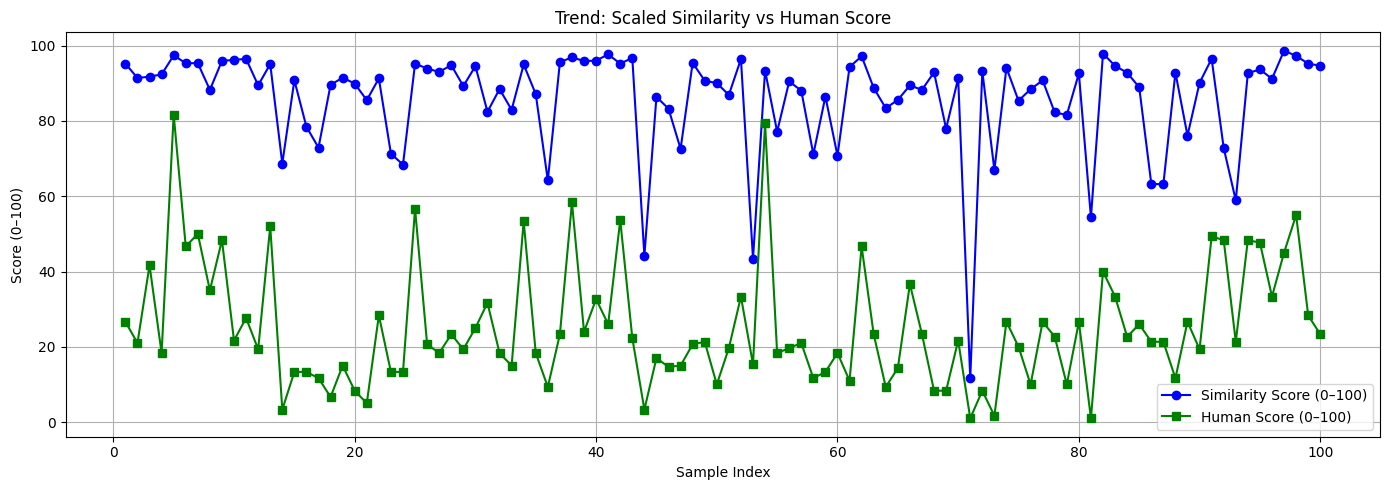

In [ ]:
similarity_scores = np.diagonal(cosine_similarity(embed_text_life_elmo_ne,embed_ref_life_elmo_ne))
similarity_scores = [s * 100 for s in similarity_scores]
human_scores = np.array(data_life['manual_average_score'].tolist())
similarity_scores = similarity_scores[:100]
human_scores = human_scores[:100]
x = np.arange(1, 101)

# x = list(range(1, len(similarity_scores) + 1))  # Question or sample index

plt.figure(figsize=(14, 5))
plt.plot(x, similarity_scores, label='Similarity Score (0–100)', color='blue', marker='o')
plt.plot(x, human_scores, label='Human Score (0–100)', color='green', marker='s')

plt.xlabel('Sample Index')
plt.ylabel('Score (0–100)')
plt.title('Trend: Scaled Similarity vs Human Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

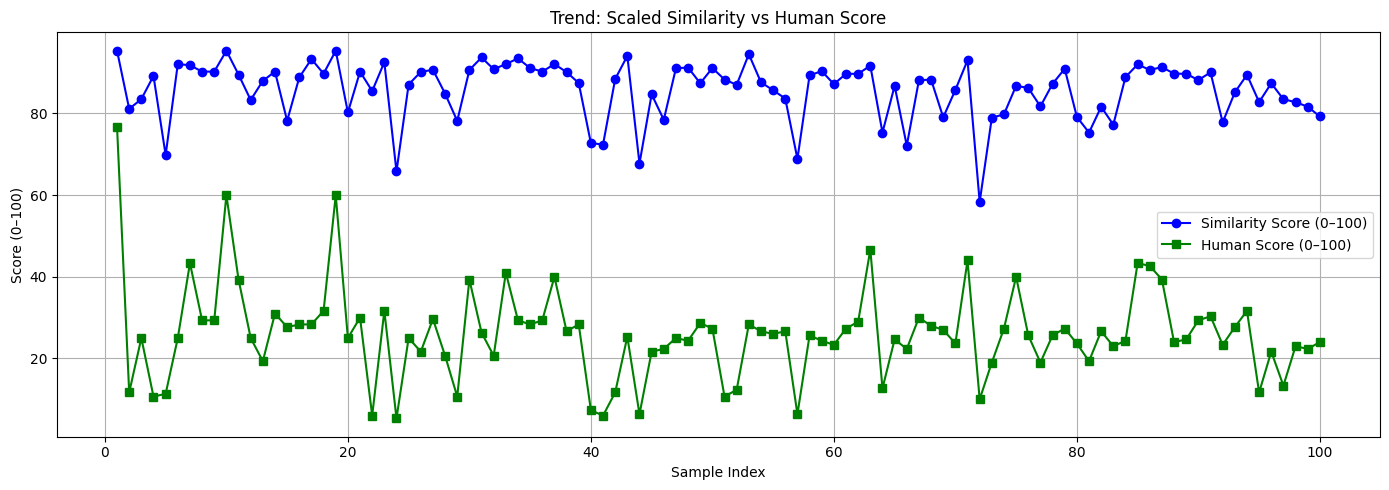

In [ ]:
similarity_scores = np.diagonal(cosine_similarity(embed_text_tech_ft_e,embed_ref_tech_ft_e))
similarity_scores = [s * 100 for s in similarity_scores]
human_scores = np.array(data_tech['manual_average_score'].tolist())
similarity_scores = similarity_scores[:100]
human_scores = human_scores[:100]
x = np.arange(1, 101)
# x = list(range(1, len(similarity_scores) + 1))  # Question or sample index

plt.figure(figsize=(14, 5))
plt.plot(x, similarity_scores, label='Similarity Score (0–100)', color='blue', marker='o')
plt.plot(x, human_scores, label='Human Score (0–100)', color='green', marker='s')

plt.xlabel('Sample Index')
plt.ylabel('Score (0–100)')
plt.title('Trend: Scaled Similarity vs Human Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Experiment

In [ ]:
print(data_text_life[0])
print(data_ref_life[0])

sumber tenaga pemanis alami menjaga sistem imun dan sebagai keseimbangan tubuh
fungsi karbohidrat adalah sebagai pemasok energi dapat memperlancar proses pada pencernaan memberikan efek kenyang dengan kandungan selulosanya dan penyeimbang asam dan basa dalam tubuh


In [ ]:
x = "aku suka makan sate"
y = "bukannya itu dia kemarin"

a1 = embed_text_elmo(x)
a2 = embed_text_elmo(y)

print(a1)
print(cosine_similarity([a1],[a2]))

[ 0.12937404  0.25681525  0.13621211 ...  0.09669563  0.4547836
 -0.10412923]
[[0.8344592]]
